In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd


# Data Cleaning: Weather data


In [2]:
weather = pd.read_csv("C:/Users/Emily/Desktop/DSML_2023-main/Boston.csv")

In [3]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82777 entries, 0 to 82776
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     82777 non-null  object 
 1   timestamp                82777 non-null  object 
 2   temperature              82773 non-null  float64
 3   cloud_cover              82777 non-null  int64  
 4   cloud_cover_description  82777 non-null  object 
 5   pressure                 82768 non-null  float64
 6   windspeed                82740 non-null  float64
 7   precipitation            82777 non-null  float64
 8   felt_temperature         82752 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 5.7+ MB


In [4]:
weather.head()

,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Boston,2015-01-01 05:54:00,-6.0,29,Partly Cloudy,1018.58,17.0,0.0,-12.0
1,Boston,2015-01-01 06:54:00,-6.0,27,Mostly Cloudy,1017.90,17.0,0.0,-12.0
2,Boston,2015-01-01 07:54:00,-6.0,27,Mostly Cloudy,1017.22,19.0,0.0,-12.0
3,Boston,2015-01-01 08:54:00,-4.0,27,Mostly Cloudy,1016.55,20.0,0.0,-11.0
4,Boston,2015-01-01 09:54:00,-6.0,29,Partly Cloudy,1016.21,24.0,0.0,-13.0


In [5]:
weather['timestamp'] = pd.to_datetime(weather['timestamp']) #First wie transform the "timestamp" column into proper format with pd.to_datetime

In [6]:
weather = weather[weather['timestamp'].dt.year == 2021] #Now we filter only the entries for the year 2021, since 
                                                        #our Bluebikes dataset has information on 2021   
weather.head()

,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
62133,Boston,2021-01-01 00:54:00,3.0,29,Partly Cloudy,1023.99,17.0,0.0,-2.0
62134,Boston,2021-01-01 01:54:00,2.0,33,Fair,1025.68,15.0,0.0,-2.0
62135,Boston,2021-01-01 02:54:00,2.0,33,Fair,1026.02,13.0,0.0,-2.0
62136,Boston,2021-01-01 03:54:00,2.0,33,Fair,1026.70,15.0,0.0,-3.0
62137,Boston,2021-01-01 04:54:00,1.0,33,Fair,1027.38,15.0,0.0,-4.0


# Deleting null-values

In [7]:
missing_values = weather.isnull().sum() #We look whether there are any null-values which we want to get rid of
print(missing_values)
rows_with_missing_values = weather[weather.isnull().any(axis=1)]
print(rows_with_missing_values)

city                       0
timestamp                  0
temperature                2
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  3
precipitation              0
felt_temperature           2
dtype: int64
         city           timestamp  temperature  cloud_cover  \
63950  Boston 2021-03-03 16:54:00          NaN           34   
66774  Boston 2021-06-17 17:54:00         25.0           34   
68871  Boston 2021-08-24 17:54:00         31.0           28   
70297  Boston 2021-10-14 17:54:00          NaN           34   

      cloud_cover_description  pressure  windspeed  precipitation  \
63950                    Fair   1008.09        NaN            0.0   
66774                    Fair   1011.81        NaN            0.0   
68871           Mostly Cloudy   1011.13        NaN            0.0   
70297                    Fair   1011.47       20.0            0.0   

       felt_temperature  
63950               NaN  
66774       

In [8]:
weather = weather.dropna()

In [9]:
missing_values = weather.isnull().sum()
print(missing_values)


city                       0
timestamp                  0
temperature                0
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  0
precipitation              0
felt_temperature           0
dtype: int64


# Cleaning the Points of Interests Data

In [10]:
pois = pd.read_csv("C:/Users/Emily/Desktop/DSML_2023-main/Massachusetts_POIs.csv")

C:\Users\Emily\AppData\Local\Temp\ipykernel_21252\329563621.py:1: DtypeWarning: Columns (10,12,13,14,21,22,25,26,28,29,31,32,33,34,35,36,37,39,40,41,43,44,45,48,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,74,75,76,77,78,79,80,81,82,84,85,88,89,90,91,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  pois = pd.read_csv("C:/Users/Emily/Desktop/DSML_2023-main/Massachusetts_POIs.csv")


In [11]:
pois = pois[pois['addr:city'] == "Boston"] #First we filter only the Information for Boston, since we do not need
pois.head()                                #the data of Massachusetts fully

,Unnamed: 0,version,timestamp,changeset,id,tags,lat,lon,addr:city,addr:country,...,geometry,osm_type,biergarten,theatre,agrarian,cosmetics,outdoor,swimming_pool,trade,water
33,33,6,1591763622,0.0,69504856,"{""addr:state"":""MA"",""attribution"":""massDOT"",""bu...",42.338516,-71.03127,Boston,NaN,...,POINT (-71.0312728881836 42.33851623535156),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,84,4,1530115928,0.0,257486687,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.299590,-71.10173,Boston,NaN,...,POINT (-71.10173034667969 42.299591064453125),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,90,6,1593727122,0.0,257486695,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.292465,-71.10141,Boston,NaN,...,POINT (-71.10140991210938 42.29246520996094),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,96,5,1596134943,0.0,257486704,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.367275,-71.06633,Boston,NaN,...,POINT (-71.06632995605469 42.36727523803711),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,99,3,1530115932,0.0,257486710,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.334450,-71.06774,Boston,NaN,...,POINT (-71.06774139404297 42.334449768066406),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(pois.columns) #Since this particular data has a lot of columns, we are taking a look into it

Index(['Unnamed: 0', 'version', 'timestamp', 'changeset', 'id', 'tags', 'lat',
       'lon', 'addr:city', 'addr:country', 'addr:full', 'addr:housenumber',
       'addr:housename', 'addr:postcode', 'addr:place', 'addr:street', 'email',
       'name', 'opening_hours', 'operator', 'phone', 'ref', 'url', 'website',
       'amenity', 'atm', 'bank', 'bicycle_parking', 'bicycle_rental', 'bar',
       'building', 'building:levels', 'car_wash', 'dentist', 'drinking_water',
       'fast_food', 'fountain', 'fuel', 'internet_access', 'landuse',
       'library', 'office', 'parking', 'restaurant', 'school',
       'social_facility', 'source', 'start_date', 'university', 'wikipedia',
       'alcohol', 'bicycle', 'boat', 'books', 'butcher', 'clothes', 'coffee',
       'craft', 'dry_cleaning', 'fireplace', 'gas', 'hardware', 'lottery',
       'model', 'motorcycle', 'music', 'musical_instrument', 'organic', 'pet',
       'religion', 'second_hand', 'security', 'shoes', 'shop', 'ski', 'vacant',
       'v

In [13]:
pois.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 33 to 92230
Data columns (total 96 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1908 non-null   int64  
 1   version             1908 non-null   int64  
 2   timestamp           1908 non-null   int64  
 3   changeset           1610 non-null   float64
 4   id                  1908 non-null   int64  
 5   tags                1861 non-null   object 
 6   lat                 1585 non-null   float64
 7   lon                 1585 non-null   float64
 8   addr:city           1908 non-null   object 
 9   addr:country        16 non-null     object 
 10  addr:full           1 non-null      object 
 11  addr:housenumber    1878 non-null   object 
 12  addr:housename      8 non-null      object 
 13  addr:postcode       1839 non-null   object 
 14  addr:place          1 non-null      object 
 15  addr:street         1900 non-null   object 
 16  emai

In [14]:
columns_needed = ['lat','lon','addr:city','name','amenity','atm','bar','library','office','school','university','shop','tourism']
#We probably won't be needing all of it, so we only get some of it which seem logical to keep

In [15]:
new_pois = pois[columns_needed] #Creating a new dataframe with information we need


# Exploring the Amenity Column

In [16]:
new_pois.head()
#First we want to get an overview on the 'amenity' column because it has a lot of information.
amenities_overview = new_pois['amenity'].value_counts()

print(amenities_overview)

restaurant         244
fast_food          139
cafe                88
library             71
bicycle_rental      68
                  ... 
language_school      1
music_venue          1
concert_hall         1
internet_cafe        1
townhall             1
Name: amenity, Length: 73, dtype: int64


In [17]:
filter_values = ['restaurant', 'library', 'school', 'bar']#We only keep the 'important' ones which could help us with our analysis

filtered_pois = new_pois[new_pois['amenity'].isin(filter_values)]

filtered_pois.head()

,lat,lon,addr:city,name,amenity,atm,bar,library,office,school,university,shop,tourism
330,42.248200,-71.11723,Boston,Boston Police Academy,school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
961,42.336823,-71.09875,Boston,Morton R. Godine Library,library,NaN,NaN,NaN,Massachusetts College Of Art,NaN,NaN,NaN,NaN
966,42.350800,-71.06653,Boston,New England School of Law Library,library,NaN,NaN,NaN,New England School Of Law,NaN,NaN,NaN,NaN
967,42.357075,-71.14803,Boston,WGBH Media Library and Archives,library,NaN,NaN,special,NaN,NaN,NaN,NaN,NaN
971,42.362730,-71.06741,Boston,Treadwell Library,library,NaN,NaN,NaN,Massachusetts General Hospital,NaN,NaN,NaN,NaN


# Visualisation for the Point of Interests data

<Axes: >

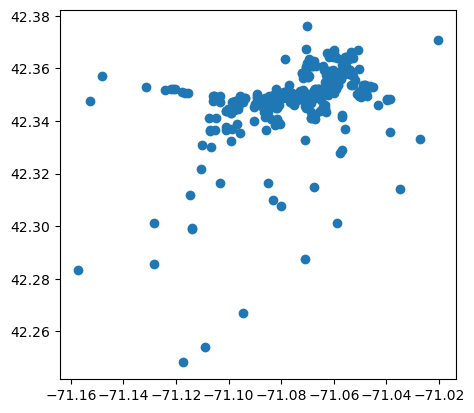

In [18]:
amenity = gpd.GeoDataFrame(filtered_pois, geometry=gpd.points_from_xy(filtered_pois['lon'], filtered_pois['lat']))
amenity.plot()

(42.25, 42.5)

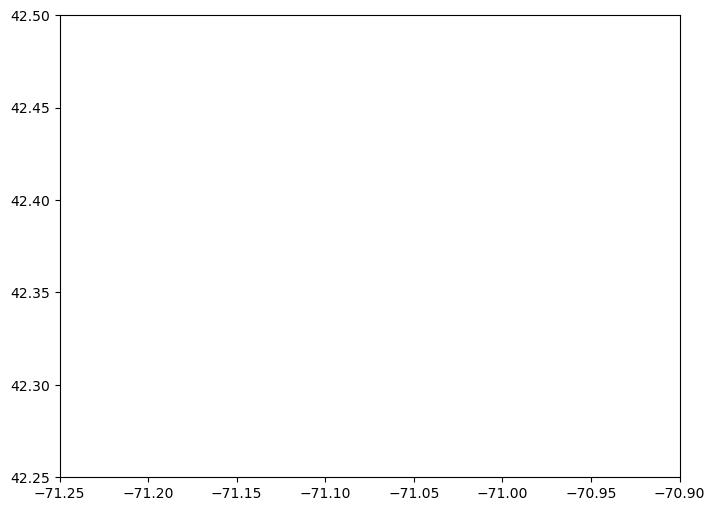

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.xlim(-71.25, -70.90)  # Replace x_min and x_max with your desired values
plt.ylim(42.25, 42.50)

In [19]:
amenity = gpd.GeoDataFrame(filtered_pois, geometry=gpd.points_from_xy(filtered_pois['lon'], filtered_pois['lat']))

new_x = (-71.25, -70.90)  # Specify the original map's longitude range
new_y = (42.25, 42.50)  # Specify the original map's latitude range

# Exploration: Bluebikes data

In [20]:
bikes = pd.read_csv("C:/Users/Emily/Desktop/DSML_2023-main/bluebikes_2021.csv")

C:\Users\Emily\AppData\Local\Temp\ipykernel_21252\1275622876.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  bikes = pd.read_csv("C:/Users/Emily/Desktop/DSML_2023-main/bluebikes_2021.csv")


In [21]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   start_time         object 
 2   end_time           object 
 3   start_station_id   int64  
 4   start_station_lat  float64
 5   start_station_lon  float64
 6   end_station_id     object 
 7   end_station_lat    float64
 8   end_station_lon    float64
 9   bike_id            int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 223.9+ MB


In [22]:
# explain what we found in the data frame (e.g. inconsistencies with column types, start_time / end-time columns, etc.)


# Data cleaning: BlueBikes Dataset

In [23]:
# explain how we are going to fix all the mistakes we found

In [24]:
# first we found that there are inconsistencies in the columns start_time and end_time:
# some of the entries don't follow the format year-month-day; hours:minutes:seconds
# to be able to change the format first we need the replace the slashes (/) with colons (:) of some values

def substitute_slashes(data, column):
    data[column] = data[column].str.replace('/', ':')
    return data

substitute_slashes(bikes, 'start_time')
substitute_slashes(bikes, 'end_time')

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062
...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484


In [25]:
# second, we transform the start_time and end_time columns to the proper format with the pd.to_datatime method

bikes[['start_time','end_time']] = bikes[['start_time','end_time']].apply(pd.to_datetime)

In [26]:
# another mistake is that the variable 'end_station_id' is an object, when it should be an integer like 'start_station_id'
# that is because some of the values in the column are also not in the proper format, instead of being whole numers
# some of them have quote symbols (") which makes the program transform the column into an object type
# so what we need to do is eliminate the quote marks of the numbers with the next function

def remove_quotes(data, column):
    data[column] = data[column].apply(lambda x: x.replace('"', '') if isinstance(x, str) else x)
    return data

bikes = remove_quotes(bikes, 'end_station_id')


In [27]:
# once all the values in the column have the same format, we can proceed to transform 
# the variable type of 'end_sation_id' to integer

def convert_column_to_integer(dataset, column_index):
    dataset[column_index] = pd.to_numeric(dataset[column_index], errors='coerce').astype('int64')
    return dataset

convert_column_to_integer(bikes, 'end_station_id')

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062
...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484


In [28]:
# we can use the info() function to confirm that the type of the variable 'end_station_id' has been changed

bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   start_station_id   int64         
 4   start_station_lat  float64       
 5   start_station_lon  float64       
 6   end_station_id     int64         
 7   end_station_lat    float64       
 8   end_station_lon    float64       
 9   bike_id            int64         
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 223.9 MB


In [29]:
# note: i'm thinking that all of the 'id' variables shouldn't be integers 
# because we are not supposed to operate with those numbers but treat them as names, should be strings ???

In [30]:
bikes.sort_values(['bike_id', 'end_time'], inplace=True)
bikes

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
356487,356485,2021-04-14 21:48:34,2021-04-14 22:03:09,171,42.374090,-71.069060,397,42.398361,-71.063738,218
364502,364500,2021-04-17 13:11:11,2021-04-17 13:44:59,397,42.398361,-71.063738,176,42.386748,-71.119019,218
366376,366374,2021-04-17 19:59:02,2021-04-17 20:22:45,176,42.386748,-71.119019,76,42.366426,-71.105495,218
366903,366901,2021-04-17 20:59:35,2021-04-17 21:23:46,76,42.366426,-71.105495,54,42.354979,-71.063348,218
367639,367637,2021-04-17 22:33:39,2021-04-17 22:59:36,54,42.354979,-71.063348,56,42.329843,-71.083866,218
...,...,...,...,...,...,...,...,...,...,...
2863170,2863160,2021-12-12 06:39:37,2021-12-12 06:53:46,74,42.373268,-71.118579,333,42.375002,-71.148716,7665
2869959,2869949,2021-12-13 14:29:21,2021-12-13 14:51:35,333,42.375002,-71.148716,76,42.366426,-71.105495,7665
2870114,2870104,2021-12-13 14:59:07,2021-12-13 15:09:55,76,42.366426,-71.105495,189,42.362428,-71.084955,7665
2882854,2882844,2021-12-15 13:53:04,2021-12-15 13:57:52,116,42.370803,-71.104412,68,42.365070,-71.103100,7665


In [31]:
bikes.sort_values(['bike_id', 'start_time'], inplace=True)

# Group the data by bike_id
grouped = bikes.groupby('bike_id')

# Calculate the idle time for each bike
bikes['idle_time'] = grouped['start_time'].shift(-1) - bikes['end_time']

# Set idle time to 0 for the last bike usage
bikes.loc[grouped['bike_id'].cumcount() == grouped['bike_id'].transform('size') - 1, 'idle_time'] = pd.Timedelta(0)

# Reset the dataframe index if needed
bikes.reset_index(drop=True, inplace=True)

In [32]:
bikes

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,idle_time
0,356485,2021-04-14 21:48:34,2021-04-14 22:03:09,171,42.374090,-71.069060,397,42.398361,-71.063738,218,2 days 15:08:02
1,364500,2021-04-17 13:11:11,2021-04-17 13:44:59,397,42.398361,-71.063738,176,42.386748,-71.119019,218,0 days 06:14:03
2,366374,2021-04-17 19:59:02,2021-04-17 20:22:45,176,42.386748,-71.119019,76,42.366426,-71.105495,218,0 days 00:36:50
3,366901,2021-04-17 20:59:35,2021-04-17 21:23:46,76,42.366426,-71.105495,54,42.354979,-71.063348,218,0 days 01:09:53
4,367637,2021-04-17 22:33:39,2021-04-17 22:59:36,54,42.354979,-71.063348,56,42.329843,-71.083866,218,3 days 18:48:35
...,...,...,...,...,...,...,...,...,...,...,...
2934383,2863160,2021-12-12 06:39:37,2021-12-12 06:53:46,74,42.373268,-71.118579,333,42.375002,-71.148716,7665,1 days 07:35:35
2934384,2869949,2021-12-13 14:29:21,2021-12-13 14:51:35,333,42.375002,-71.148716,76,42.366426,-71.105495,7665,0 days 00:07:32
2934385,2870104,2021-12-13 14:59:07,2021-12-13 15:09:55,76,42.366426,-71.105495,189,42.362428,-71.084955,7665,1 days 22:43:09
2934386,2882844,2021-12-15 13:53:04,2021-12-15 13:57:52,116,42.370803,-71.104412,68,42.365070,-71.103100,7665,0 days 00:01:16


In [33]:
bikes.sort_values(['end_station_id'], inplace=True)
bikes

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,idle_time
270459,1747872,2021-09-04 08:45:47,2021-09-14 21:43:18,331,42.336586,-71.098870,1,42.387151,-71.075978,2530,4 days 19:09:59
1905792,465839,2021-05-01 20:13:21,2021-05-03 15:58:54,55,42.347406,-71.086784,1,42.387151,-71.075978,5646,0 days 07:40:44
1712012,49660,2021-01-21 13:22:09,2021-01-21 13:36:38,496,42.398444,-71.107833,1,42.387151,-71.075978,5333,6 days 07:06:28
1420535,1380703,2021-08-03 17:25:18,2021-08-03 17:47:06,139,42.361780,-71.108100,1,42.387151,-71.075978,4871,1 days 02:28:52
2485847,2711372,2021-11-18 11:23:27,2021-11-18 11:36:28,437,42.372077,-71.089954,1,42.387151,-71.075978,6557,2 days 03:54:18
...,...,...,...,...,...,...,...,...,...,...,...
2327780,2894239,2021-12-17 04:14:37,2021-12-17 04:43:41,47,42.362811,-71.056067,554,42.339202,-71.090511,6326,0 days 08:06:52
2265339,2797943,2021-12-01 23:21:50,2021-12-01 23:26:55,364,42.338896,-71.081500,554,42.339202,-71.090511,6221,0 days 02:30:05
2327776,2892914,2021-12-16 23:44:12,2021-12-16 23:58:06,4,42.345392,-71.069616,554,42.339202,-71.090511,6326,0 days 00:14:26
1133389,2827957,2021-12-06 10:45:26,2021-12-06 10:51:29,360,42.329463,-71.090158,554,42.339202,-71.090511,4201,0 days 03:52:47


In [34]:
# Group the data by end_station_id and calculate the sum of idle time
station_idle_sum = bikes.groupby('end_station_id')['idle_time'].sum()

# Reset the index and rename the columns
station_idle_sum = station_idle_sum.reset_index()
station_idle_sum.columns = ['end_station_id', 'idle_time_sum']
station_idle_sum.rename(columns={'end_station_id':'station_id'}, inplace=True)

station_idle_sum

,station_id,idle_time_sum
0,1,2319 days 09:23:43
1,3,2894 days 10:37:18
2,4,4750 days 06:43:39
3,5,1908 days 00:44:29
4,6,2990 days 23:36:04
...,...,...
422,548,6 days 00:50:59
423,549,1131 days 08:26:23
424,550,116 days 16:48:14
425,553,394 days 13:38:19


In [35]:
# Group the data by end_station_id and calculate the average idle time
station_idle_mean = bikes.groupby('end_station_id')['idle_time'].mean()

# Reset the index and rename the columns
station_idle_mean = station_idle_mean.reset_index()
station_idle_mean.columns = ['end_station_id', 'idle_time_mean']
station_idle_mean.rename(columns={'end_station_id':'station_id'}, inplace=True)
station_idle_mean

,station_id,idle_time_mean
0,1,3 days 04:53:09.258287292
1,3,0 days 07:31:01.988745806
2,4,0 days 09:15:24.473773952
3,5,0 days 03:08:06.722511296
4,6,0 days 03:24:54.051569933
...,...,...
422,548,0 days 20:41:34.142857142
423,549,0 days 10:00:29.776262440
424,550,0 days 10:38:58
425,553,0 days 17:24:26.726102941


<Axes: >

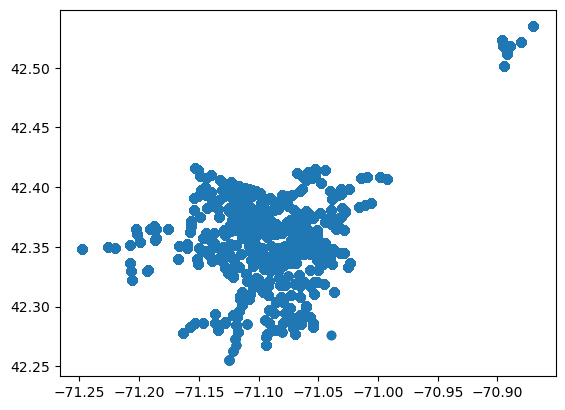

In [36]:
#location of stations
columns = ['start_station_id','start_station_lat','start_station_lon']
stations_df = bikes[columns]
stations_df = stations_df.drop_duplicates(subset=['start_station_id'])
stations_df.head()
start_station_id = gpd.GeoDataFrame(bikes, geometry=gpd.points_from_xy(bikes['start_station_lon'], bikes['start_station_lat']))
start_station_id.plot()

# Creating a dataframe for the Station locations

In [37]:
#We want to include the locations of the stations into our POIs dataframe to analyze the distances between them and other locations

In [42]:
start_station_id = bikes.drop(columns=['start_time', 'end_time','end_station_id','end_station_lat' , 'end_station_lon', 'bike_id' , 'idle_time'])
end_station_id = bikes.drop(columns=['start_time', 'end_time','start_station_id','start_station_lat' , 'start_station_lon', 'bike_id' , 'idle_time'])
start_station_id.rename(columns={'start_station_id':'station_id'}, inplace=True)
end_station_id.rename(columns={'end_station_id':'station_id'}, inplace=True)
start_station_id.rename(columns={'start_station_lat':'lat'}, inplace=True)
start_station_id.rename(columns={'start_station_lon':'lon'}, inplace=True)
end_station_id.rename(columns={'end_station_lon':'lon'}, inplace=True)
end_station_id.rename(columns={'end_station_lat':'lat'}, inplace=True)

In [43]:
station_id = end_station_id.append(start_station_id, ignore_index=True)
station_id = station_id.drop_duplicates(subset=['station_id'])

C:\Users\Emily\AppData\Local\Temp\ipykernel_21252\973159434.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  station_id = end_station_id.append(start_station_id, ignore_index=True)


In [66]:
station_id.head()

,Unnamed: 0,station_id,station_lat,station_lon,column
0,1747872,1,42.387151,-71.075978,NaN
724,829606,3,42.340115,-71.100619,NaN
9965,1252302,4,42.345392,-71.069616,NaN
22281,1551490,5,42.341814,-71.090179,NaN
36887,2400437,6,42.361257,-71.065287,NaN


In [45]:
pois_merged = filtered_pois.append(station_id, ignore_index=True)#merge bikes_loc and POIs dataframe

C:\Users\Emily\AppData\Local\Temp\ipykernel_21252\3891400422.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pois_merged = filtered_pois.append(station_id, ignore_index=True)#merge bikes_loc and POIs dataframe


In [46]:
pois_merged.head()

,lat,lon,addr:city,name,amenity,atm,bar,library,office,school,university,shop,tourism,Unnamed: 0,station_id
0,42.248200,-71.11723,Boston,Boston Police Academy,school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42.336823,-71.09875,Boston,Morton R. Godine Library,library,NaN,NaN,NaN,Massachusetts College Of Art,NaN,NaN,NaN,NaN,NaN,NaN
2,42.350800,-71.06653,Boston,New England School of Law Library,library,NaN,NaN,NaN,New England School Of Law,NaN,NaN,NaN,NaN,NaN,NaN
3,42.357075,-71.14803,Boston,WGBH Media Library and Archives,library,NaN,NaN,special,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42.362730,-71.06741,Boston,Treadwell Library,library,NaN,NaN,NaN,Massachusetts General Hospital,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
bikes.rename(columns={'start_time':'timestamp'}, inplace=True)


In [48]:
bikes_idle_avg = bikes.groupby(pd.PeriodIndex(bikes['timestamp'], freq="W"))['idle_time'].mean() 
#here we calculate the bike idle time average for every week to see when the idle time was highest (season, weather ...)

In [49]:
weather_temp_avg = weather.groupby(pd.PeriodIndex(weather['timestamp'], freq="W"))['temperature'].mean() 
#here we calculate the weather average for every week, to merge it with the average idle time 

In [50]:
weather_temp_avg.to_frame().join(bikes_idle_avg) #merged table for weather and bikes idle time average

,temperature,idle_time
timestamp,,
2020-12-28/2021-01-03,2.114583,1 days 15:49:32.314375367
2021-01-04/2021-01-10,0.197917,1 days 00:12:06.293619355
2021-01-11/2021-01-17,2.611940,0 days 23:24:03.724503597
2021-01-18/2021-01-24,-0.366279,1 days 04:02:08.981451654
2021-01-25/2021-01-31,-4.322870,1 days 10:42:22.692393380
2021-02-01/2021-02-07,-0.111607,1 days 08:04:26.363000864
2021-02-08/2021-02-14,-4.082927,1 days 03:15:44.559576917
2021-02-15/2021-02-21,-1.551867,1 days 05:22:03.746419478
2021-02-22/2021-02-28,3.043243,0 days 22:12:00.341987466


In [51]:
weather.corr().round(2) #a correlation table to see what column is correlating with which one

C:\Users\Emily\AppData\Local\Temp\ipykernel_21252\1016649083.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  weather.corr().round(2) #a correlation table to see what column is correlating with which one


,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature
temperature,1.00,0.08,-0.06,-0.07,0.04,0.99
cloud_cover,0.08,1.00,0.24,-0.04,-0.15,0.08
pressure,-0.06,0.24,1.00,-0.31,-0.13,-0.04
windspeed,-0.07,-0.04,-0.31,1.00,0.07,-0.12
precipitation,0.04,-0.15,-0.13,0.07,1.00,0.04
felt_temperature,0.99,0.08,-0.04,-0.12,0.04,1.00


In [52]:
bikes.head()

,Unnamed: 0,timestamp,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,idle_time
270459,1747872,2021-09-04 08:45:47,2021-09-14 21:43:18,331,42.336586,-71.098870,1,42.387151,-71.075978,2530,4 days 19:09:59
1905792,465839,2021-05-01 20:13:21,2021-05-03 15:58:54,55,42.347406,-71.086784,1,42.387151,-71.075978,5646,0 days 07:40:44
1712012,49660,2021-01-21 13:22:09,2021-01-21 13:36:38,496,42.398444,-71.107833,1,42.387151,-71.075978,5333,6 days 07:06:28
1420535,1380703,2021-08-03 17:25:18,2021-08-03 17:47:06,139,42.361780,-71.108100,1,42.387151,-71.075978,4871,1 days 02:28:52
2485847,2711372,2021-11-18 11:23:27,2021-11-18 11:36:28,437,42.372077,-71.089954,1,42.387151,-71.075978,6557,2 days 03:54:18


# Create new latitude and longitude points for the map

C:\Users\Emily\AppData\Local\Temp\ipykernel_21252\3337358240.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_pois = filtered_pois.append(new_points, ignore_index=True)


Text(0.5, 1.0, 'POIs Amenities')

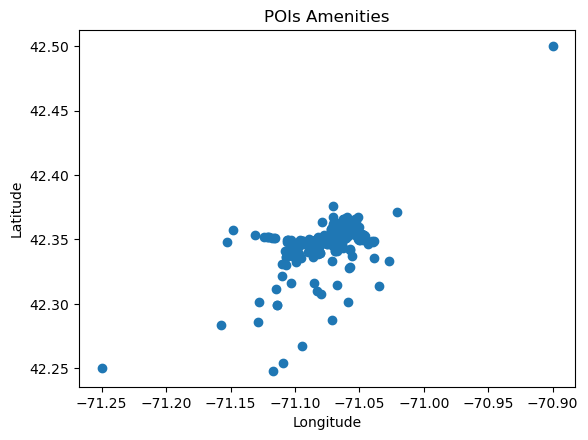

In [53]:
new_points = pd.DataFrame({
    'lat': [42.25, 42.50],
    'lon': [-71.25, -70.90]
})
filtered_pois = filtered_pois.append(new_points, ignore_index=True)
amenity = gpd.GeoDataFrame(filtered_pois, geometry=gpd.points_from_xy(filtered_pois['lon'], filtered_pois['lat']))
amenity.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('POIs Amenities')

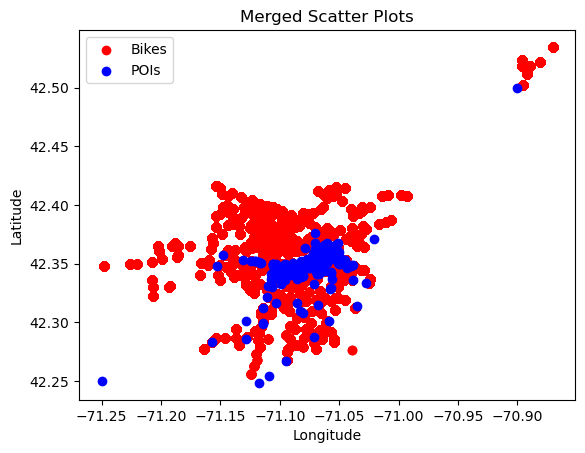

In [54]:
plt.scatter(bikes['start_station_lon'], bikes['start_station_lat'], c='red', label='Bikes')
plt.scatter(filtered_pois['lon'], filtered_pois['lat'], c='blue', label='POIs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Merged Scatter Plots')
plt.legend()
plt.show()

In [58]:
station_id["column"] = np.nan #we want to merge two dataframes, so we added a new column to merge it
filtered_pois["column"] = np.nan
station_id.rename(columns={'lon':'station_lon'}, inplace=True)
station_id.rename(columns={'lat':'station_lat'}, inplace=True)
filtered_pois.rename(columns={'lat':'amenity_lat'}, inplace=True)
filtered_pois.rename(columns={'lon':'amenity_lon'}, inplace=True)

In [67]:
POIS = filtered_pois.append(station_id, ignore_index=True)#Merging the POIS df with station_ids

C:\Users\Emily\AppData\Local\Temp\ipykernel_21252\10749429.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  POIS = filtered_pois.append(station_id, ignore_index=True)#Merging the POIS df with station_ids


In [68]:
POIS

,amenity_lat,amenity_lon,addr:city,name,amenity,atm,bar,library,office,school,university,shop,tourism,column,Unnamed: 0,station_id,station_lat,station_lon
0,42.248200,-71.11723,Boston,Boston Police Academy,school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42.336823,-71.09875,Boston,Morton R. Godine Library,library,NaN,NaN,NaN,Massachusetts College Of Art,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,42.350800,-71.06653,Boston,New England School of Law Library,library,NaN,NaN,NaN,New England School Of Law,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,42.357075,-71.14803,Boston,WGBH Media Library and Archives,library,NaN,NaN,special,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42.362730,-71.06741,Boston,Treadwell Library,library,NaN,NaN,NaN,Massachusetts General Hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550182.0,548.0,42.268100,-71.119240
809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2381359.0,549.0,42.364739,-71.059349
810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2592649.0,550.0,42.386400,-71.096010
811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2842828.0,553.0,42.371141,-71.076198
